# Sale of Alcohol Prediction using LSTM

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

## 1.ETL

In [ ]:
df = pd.read_csv('../data/Alcohol_Sales.csv',index_col=0,parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [ ]:
df.shape

(325, 1)

In [ ]:
df = df.rename(columns= {'S4248SM144NCEN':'Sales'})
df.columns

Index(['Sales'], dtype='object')

## 2.EDA

In [ ]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


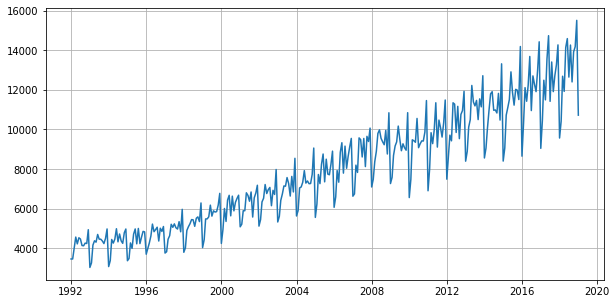

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Sales'])
plt.grid()
#optionally, you need title, xaxis, yaxis, etc.

## 3. Feature Extraction

In [ ]:
y = df['Sales'].values.astype('float') #.values is basically getting numpy array of pandas
y.shape

(325,)

In [ ]:
#test size
test_size = 10

train_set = y[:-test_size]
test_set = y[-test_size:]

In [ ]:
len(train_set),len(test_set)

(315, 10)

## 4. Prepocessing

In anything, for neural network, it's better to normalize, so to reach convergence faster.... 

Two ways are:

1.Standardizing - normalize aorund the mean $\displaystyle\frac{x_i-\mu}{\sigma}$

2.MinMax - $\displaystyle\frac{x_i-x_\text{min}}{x_\text{max}-x_\text{min}}$

In signal, we cannot the trust the mean, so MinMax is better

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range=(-1,1)) #by defauly 0,1
#for signal, -1 to 1 is good way to normalize

In [ ]:
#to prevent data lekage, you only scale the train set independently of test set
#scalar.fit_transform((m,n))
train_minmax = scalar.fit_transform(train_set.reshape(-1,1))

In [ ]:
train_minmax.min(), train_minmax.max(), train_minmax.mean()

(-1.0, 1.0, -0.20000108542719033)

In [ ]:
# train_minmax = torch.FloatTensor(train_minmax.reshape(-1)) #or
train_minmax = torch.FloatTensor(train_minmax).view(-1)
train_minmax.size()

torch.Size([315])

## 5. Create our batch creator

In [ ]:
window_size = 10

def input_data(seq, window_size,label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size): #if not, we will go out of bound
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+label_size]
        out.append((window,label))
    return out

#question: if my window is 10, label size is 1, my seq is ???
#        : then what is the shape of out

In [ ]:
train_data = input_data(train_minmax,window_size)

len(train_data) 

305

In [ ]:
train_data[0] #sample should be simply(10,1)

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901]),
 tensor([-0.7933]))

## 6. Define the model

In [ ]:
class LSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size =1
    def __init__(self,input_size = 1 ,hidden_size = 100, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,out_size) #taking the last hidden state

        #optional 
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))

    def forward(self, seq):
        #seq shape : 10 
        seq = seq.reshape(len(seq),1,-1)
        #seq shape : (10, 1, 1)
        out, (_,_) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape : (L, N, Hout * D) ==> (10, 1, 100)
        #get the last hidden state
        out = out[-1,:,:] #(B, Hout)
        #out shape : (1,100) 
        out = self.linear(out)
        #out shape : (1, 1)
        return out

## 7. Training!!

In [ ]:
torch.manual_seed(9999)

model = LSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 40000????

   400
 40000
   400
   400
   100
     1
______
 41301


In [ ]:
epochs = 50
future = 40

for e in range(epochs):
    
    for seq, y_train in train_data:
        #seq : (10, ) #y_train : (1, )
        # print(seq.shape)
        # print(y_train.shape)
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        # print(yhat.shape, y_train.shape)
        loss = criterion(yhat,y_train) #2. loss
        optimizer.zero_grad() #3. zero_grad
        loss.backward() #4. backward
        optimizer.step() #5. step

    if e%10 == 0 :
        print(f'Epoch : {e:2.0f} - Loss : {loss:.5f}')

Epoch :  0 - Loss : 0.00066
Epoch : 10 - Loss : 0.00113
Epoch : 20 - Loss : 0.00329
Epoch : 30 - Loss : 0.01821
Epoch : 40 - Loss : 0.00895


## 8. Plot the loss
Skip for brevity

## 9. Inference

In [ ]:
future = window_size
#prepare a lsit of predictions and append on this list
preds = train_minmax[-window_size:].tolist()

#usually we do with torch.no_grad():
model.eval() #same effect as no_grad(): all gradients
#i just read the documenttation and dobule check
#model.eval() turns off dropout and batchnorm during, but not gradient
for _ in range(future):
    #act as the current train
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        yhat = model(seq)
        yhat = yhat.reshape(-1)
        preds.append(yhat.item()) 

preds[-window_size:]

[0.5482634902000427,
 0.9146734476089478,
 0.993611216545105,
 0.4111730754375458,
 0.6853599548339844,
 0.6263508796691895,
 0.6590077877044678,
 0.7917673587799072,
 1.0403138399124146,
 0.06374809145927429]

## 10. Denormalize our data!

In [ ]:
scalar #it already fit, so itknow how to inverse

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
preds_real = scalar.inverse_transform(np.array(preds).reshape(-1,1))

In [ ]:
preds_real[-window_size:]

array([[12087.56728593],
       [14230.88233179],
       [14692.62881118],
       [11285.65690477],
       [12889.5130558 ],
       [12544.33947062],
       [12735.36605418],
       [13511.94316518],
       [14965.81580657],
       [ 9253.39446099]])

In [ ]:
test_set

array([11919., 14138., 14583., 12640., 14257., 12396., 13914., 14174.,
       15504., 10718.])